##  Notes on how to use PyTorch by training a simple neural network to classify MNIST dataset.
for my personal reference and understanding

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### Notes on how to load data and what transform does
- transforms is used to transform the data (preprocess it) before it is fed to the model
- transforms.Compose is used to compose multiple transforms in parralel, performance thing.
- **transforms.ToTensor()** is used to convert the Image into a tensor.
- **transforms.Normalize** is used to normalize the data (make it so that the data is between 0 and 1), Here it takes the mean and std deviation of the data and then normalizes it.
    - **transforms.Normalize((0.5,), (0.5,))** normalizes the data using mean=0.5 and std=0.5
    - For each pixel value x, it applies: (x - 0.5) / 0.5
    - This centers the data around 0 and scales it, but doesn't restrict it to a specific range
    - The resulting values can be outside the [-1, 1] range, depending on the original pixel values


In [15]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



 ### Notes on the Neural Network Model (MnistNN)

 1. Model Structure:
   - Input layer: 28*28 = 784 neurons (flattened 28x28 pixel image)
   - First hidden layer: 128 neurons
   - Second hidden layer: 64 neurons
   - Output layer: 10 neurons (one for each digit 0-9)

 2. Layer Connections:
    - fc1: Connects input (784) to first hidden layer (128)
   - fc2: Connects first hidden layer (128) to second hidden layer (64)
   - fc3: Connects second hidden layer (64) to output layer (10)

 3. Activation Functions:
   - ReLU (Rectified Linear Unit) used after fc1 and fc2
   - No activation function after fc3 (raw logits for CrossEntropyLoss)

 4. Forward Pass:
   - Flattens input image to 1D tensor
   - Applies linear transformations and activations sequentially
   - Returns logits for 10 possible digit classes

5. Note on Implementation:
   - Uses PyTorch's nn.Module as base class
    - Defines layers in __init__ method
   - Implements forward pass logic in forward method

 6. Activation Functions:
    - Purpose: Activation functions introduce non-linearity into the neural network.
    - Without activation functions, the network would be equivalent to a single linear transformation.
    - They allow the network to learn complex patterns and relationships in the data.
    - ReLU (Rectified Linear Unit) is commonly used because:
      a) It's computationally efficient (simple max operation).
      b) It helps mitigate the vanishing gradient problem.
      c) It allows for sparse activation, as negative inputs are mapped to zero.
    - In our model, ReLU helps the network capture non-linear relationships between features at different layers.



In [59]:
class MnistNN(nn.Module):
   def __init__(self):
      super(MnistNN, self).__init__()
      self.fc1 = nn.Linear(28*28, 256) # 28*28 is the size of the input image (28x28 pixels), 128 is the number of output features
      self.fc2 = nn.Linear(256, 128)
      self.fc3 = nn.Linear(128, 32) # 128 is the number of input features, 64 is the number of output features
      self.fc4 = nn.Linear(32, 10) # 64 is the number of input features, 10 is the number of output features (10 numbers it could be)

   def forward(self, x: torch.Tensor):
      x = x.view(-1, 28*28) # Flatten the input image
      x = torch.relu(self.fc1(x)) # relu on the first layer
      x = torch.relu(self.fc2(x)) # relu on the second layer
      x = torch.relu(self.fc3(x)) # relu on the third layer
      x = self.fc4(x) # linear layer (logits)
      return x



# Model, Loss Function, and Optimizer

Model (MnistNN)
- Custom neural network for MNIST digit classification
- Three fully connected layers: 784 -> 128 -> 64 -> 10

Loss Function (CrossEntropyLoss)
- Used for multi-class classification
- Formula: $L = -\log(\frac{\exp(x[\text{class}])}{\sum_{j \in C} \exp(x[j])})$
- Penalizes confident incorrect predictions more heavily

Optimizer (Adam)
- We use the Adam optimizer (`optim.Adam`) to update our model's parameters.
- Adam is an adaptive learning rate optimization algorithm.
- It's efficient and well-suited for problems with a large amount of data/parameters.
- We set the learning rate to 0.001, which is a common starting point.

Training process:
1. Model predicts
2. Loss function calculates error
3. Optimizer updates model parameters


In [64]:
model = MnistNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [65]:
epochs = 15  # number of times we go through the entire dataset
loss_history = []

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad() # set the gradients to zero so they don't accumulate

        outputs = model(images) # forward pass
        loss = loss_fn(outputs, labels) # calculate the loss

        loss.backward() # backward pass (backpropagation and gradient calc)
        optimizer.step() # update the weights

        running_loss += loss.item() # add the loss to the running loss

    loss_history.append(running_loss/len(trainloader))
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}") # print the loss

print("Training complete")
print("prev loss was 0.03538552442036107")


Epoch 1, Loss: 0.3869182396290907
Epoch 2, Loss: 0.17123947873401807
Epoch 3, Loss: 0.12399035990277905
Epoch 4, Loss: 0.09817120627309484
Epoch 5, Loss: 0.08328425739608857
Epoch 6, Loss: 0.07244165815752564
Epoch 7, Loss: 0.06455592351428457
Epoch 8, Loss: 0.05652062714818234
Epoch 9, Loss: 0.05106595626981087
Epoch 10, Loss: 0.04973102138806651
Epoch 11, Loss: 0.0414939702417491
Epoch 12, Loss: 0.04334280815059026
Epoch 13, Loss: 0.03582564822441813
Epoch 14, Loss: 0.03420276469057069
Epoch 15, Loss: 0.034778480024100826
Training complete
prev loss was 0.03538552442036107


# Sigmoid vs ReLU Activation Functions

 Based on the training loss progression, we can see that our model using ReLU activation function performs well, with the loss decreasing steadily over epochs. This performance can be contrasted with potential limitations of using sigmoid activation:

1. Vanishing Gradient Problem:
   - Sigmoid function saturates and kills gradients for very high or very low inputs.
   - This can slow down or even stop learning in deep networks.
   - ReLU doesn't suffer from this as its gradient is always 1 for positive inputs.

2. Non-Zero Centered Output:
   - Sigmoid outputs are not zero-centered, which can introduce undesirable zig-zagging dynamics in gradient descent.
   - ReLU also suffers from this, but its sparsity and non-saturating nature often outweigh this drawback.

3. Computational Efficiency:
   - Sigmoid involves expensive exponential operations.
   - ReLU is simply a max operation, making it computationally efficient.

4. Sparsity:
   - ReLU can result in true zero activations, introducing sparsity in the network (some neurons are not activated).
   - Sparsity can be beneficial for feature learning and the model being able to generalize better.



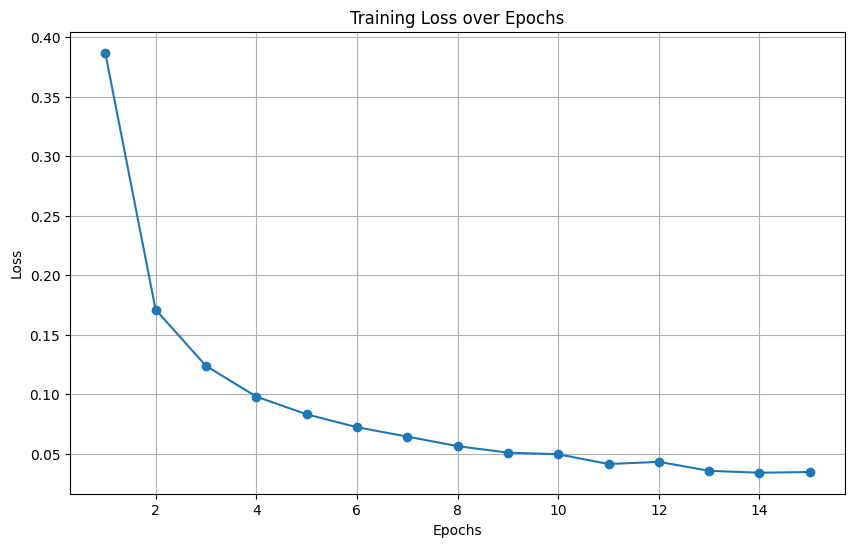

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Model Evaluation

After training our model, we need to evaluate its performance on the test dataset. This process helps us understand how well our model generalizes to unseen data. Here's what the code in the next cell does:

1. **Initialization**: We set up counters for correct predictions and total samples.
   ```python
   correct = 0
   total = 0
   ```

2. **Disabling Gradient Calculation**: We use `torch.no_grad()` to disable gradient calculations, which aren't needed during inference and helps save memory and computation time.
   ```python
   with torch.no_grad():
   ```

3. **Iterating Through Test Data**: We loop through our test dataset using the `testloader`.
   ```python
   for images, labels in testloader:
   ```

4. **Making Predictions**: For each batch of images, we use our trained model to make predictions.
   ```python
   outputs = model(images)
   _, predicted = torch.max(outputs, 1)
   ```
   `predicted` is a tensor of shape (batch_size (x-axis), 1 (y-axis)) containing the predicted labels for each image in the batch. ex. [1,7,0] - these are the indices of the highest value in the output tensor which corresponds to the actual predicted label.

5. **Calculating Accuracy**: We compare the predicted labels with the true labels and keep a count of correct predictions.
   ```python
   total += labels.size(0)
   correct += (predicted == labels).sum().item()
   ```

6. **Reporting Results**: Finally, we calculate and print the overall accuracy of our model on the test dataset.
   ```python
   print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")
   ```

This evaluation step is crucial as it gives us an unbiased estimate of how well our model performs on new, unseen data.


In [72]:
correct = 0
total = 0


with torch.no_grad():  # disable gradient calculations for inference
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # get the index of the highest value in the output (which is the predicted label)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # count how many are correct

print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")


Accuracy of the network on the 10000 test images: 97.62%


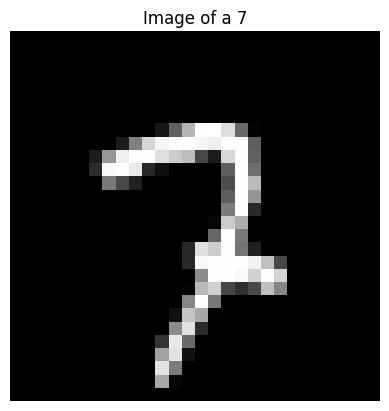

Predicted: 7
Actual: 7


In [79]:
dataiter = iter(testloader)
images, labels = next(dataiter)

img = images[41].squeeze() # squeeze removes the extra dimension that torch adds to the image. dims are (1,28,28) -> (28,28), 1 represents the batch size
label = labels[41].item() # item() converts the label to a python integer

plt.imshow(img, cmap='gray')
plt.title(f"Image of a {label}")
plt.axis('off')
plt.show()

img_tensor = img.unsqueeze(0) # unsqueeze adds a dimension to the tensor of size 1, in this case it adds a batch size of 1

with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)

print(f"Predicted: {predicted.item()}")
print(f"Actual: {label}")
